In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime
import calendar
from scipy import stats

In [12]:
sn.set_style("whitegrid")
path = '/home/vzzzz/Downloads/kaggle_bike/'

In [4]:
trainData = pd.read_csv(path+'train.csv')

In [5]:
trainData.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
trainData.shape

(10886, 12)

In [7]:
trainData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

### Из описания датасета:
<br>datetime - hourly date + timestamp  
season:  
>1 = spring,<br>2 = summer,<br>3 = fall,<br>4 = winter

holiday - whether the day is considered a holiday
<br>workingday - whether the day is neither a weekend nor holiday
<br>weather:
>1: Clear, Few clouds, Partly cloudy, Partly cloudy<br>2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds,Mist<br>3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds <br>4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius
<br>atemp - "feels like" temperature in Celsius
<br>humidity - relative humidity
<br>windspeed - wind speed
<br>casual - number of non-registered user rentals initiated
<br>registered - number of registered user rentals initiated
<br>count - number of total rentals

Для начала визуализируем среднее количество арендованных велосипедов за всё время

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
  from ipykernel import kernelapp as app


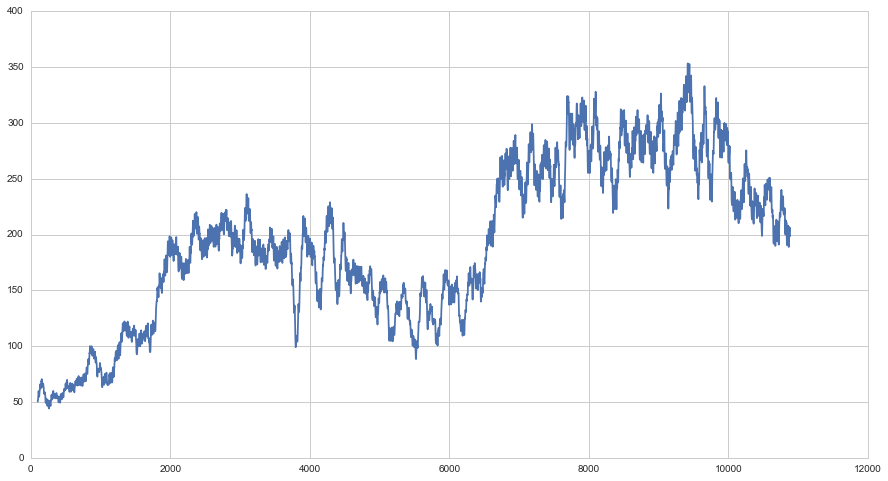

In [52]:
fig, axes = plt.subplots(figsize=(15, 8))
plt.plot(pd.rolling_mean(trainData['count'], 100))

Разделим данные на нужные нам признаки в соответсвии с описанием. Логично предположить, что можно составить некоторое распределение количества арендованных велосипедов в заисимости от сезона, дня недели, времени суток, погоды и "красноты" дня календаря.

In [8]:
trainData["date"] = trainData.datetime.apply(lambda x : x.split()[0])
trainData["hour"] = trainData.datetime.apply(lambda x : x.split()[1].split(":")[0])
trainData["weekday"] = trainData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
trainData["month"] = trainData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
trainData["season"] = trainData.season.map({1: "spring", 
                                            2 : "summer", 
                                            3 : "autumn", 
                                            4 :"winter" })
trainData["weather"] = trainData.weather.map({1: "clear",
                                              2 : "mist",
                                              3 : "lightsnow",
                                              4 :"heavyrain" })

Я тут подсмотрел, как можно с категориальными переменными в датафреймах работать. Собственно, группируем соответсвующие столбцы по нужному типу, попутно дропаем ненужный уже "datetime"

In [9]:
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    trainData[var] = trainData[var].astype("category")
trainData  = trainData.drop(["datetime"],axis=1)

Распределение по сезонам и рабочим/нерабочим дням

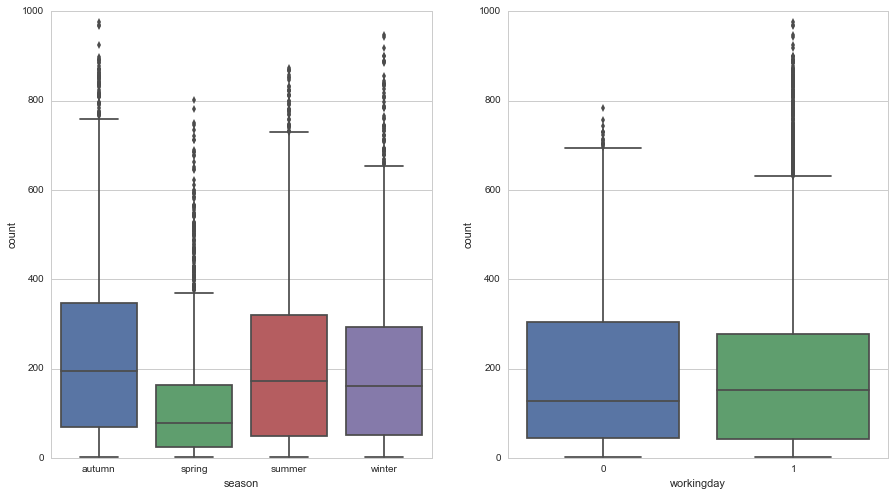

In [13]:
fig, axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(15, 8)

sn.boxplot(data=trainData, y="count",x="season", ax=axes[0])
sn.boxplot(data=trainData, y="count",x="workingday", ax=axes[1])

axes[0].set(xlabel='season', ylabel='count')
axes[1].set(xlabel='workingday', ylabel='count')

И, наверно, самое интересное: распределение по времени суток

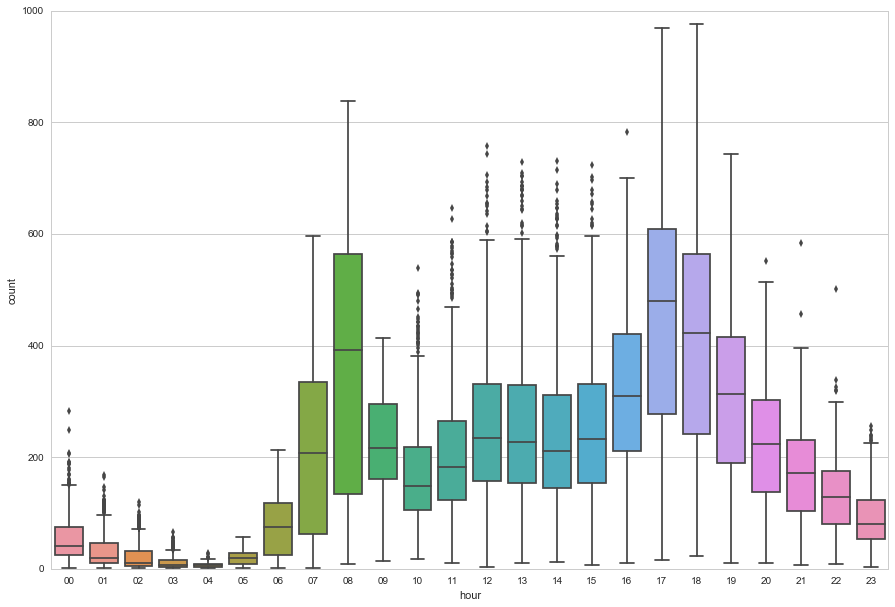

In [14]:
fix, axes = plt.subplots(figsize=(15, 10))
sn.boxplot(data=trainData, y="count",x="hour", ax=axes)

Опять же подсмотренное: из проедыдущих графиков видно, что есть измерения, которые выбиваются из распределения. Для построенной модели в моём случае это подняло точность процентов на пару. Хотя при этом дропнули около 1% датасета. 

In [19]:
trainDataWithoutOutliers = trainData[np.abs(trainData["count"]-trainData["count"].mean())
                                     <=(3*trainData["count"].std())] 
trainDataWithoutOutliers.shape

(10739, 15)

Корреляция некатегориальых признаков

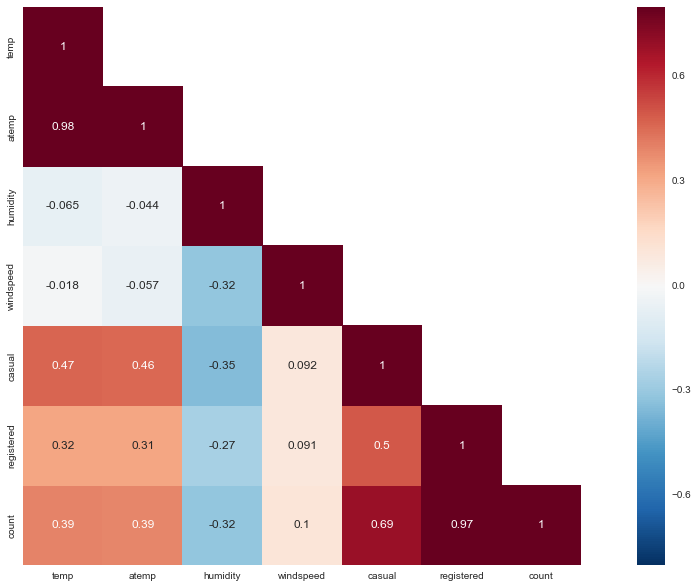

In [27]:
corrMat = trainData.corr()
mask = np.array(corrMat)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMat, mask=mask,vmax=.8, square=True,annot=True)

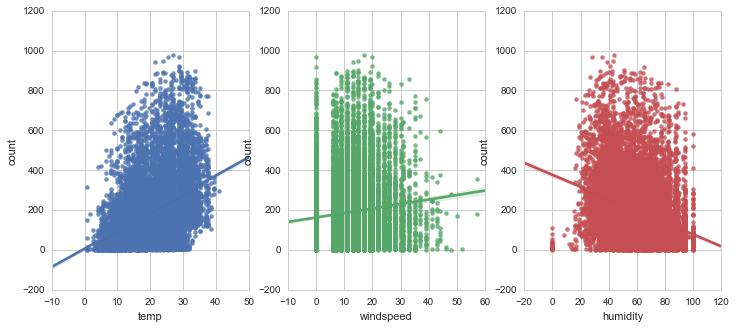

In [40]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="count", data=trainData,ax=ax1)
sn.regplot(x="windspeed", y="count", data=trainData,ax=ax2)
sn.regplot(x="humidity", y="count", data=trainData,ax=ax3)

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([ 0.69314718,  0.69314718,  0.69314718, ...,  6.5971457 ,
          6.59850903,  6.5998705 ])),
 (1.3486990121229776, 4.5624238680878078, 0.95811767809096171))

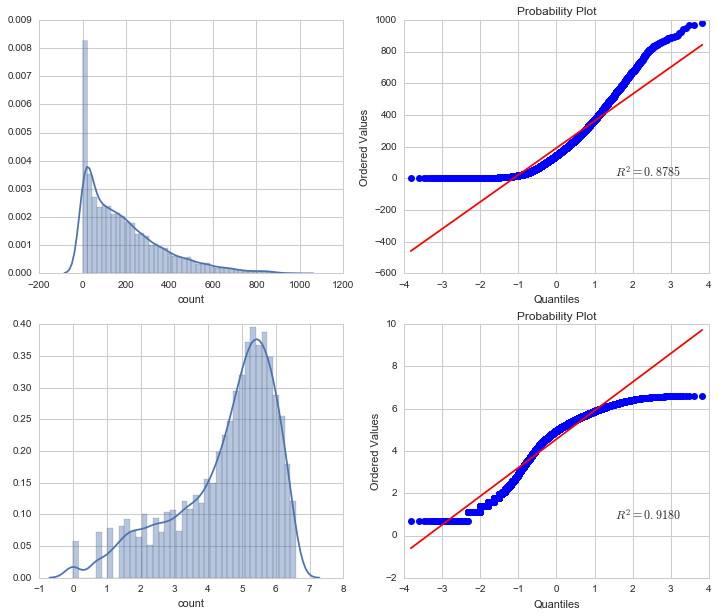

In [42]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(trainData["count"],ax=axes[0][0])
stats.probplot(trainData["count"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(trainDataWithoutOutliers["count"]),ax=axes[1][0])
stats.probplot(np.log1p(trainDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

ValueError: Could not interpret input 'month'

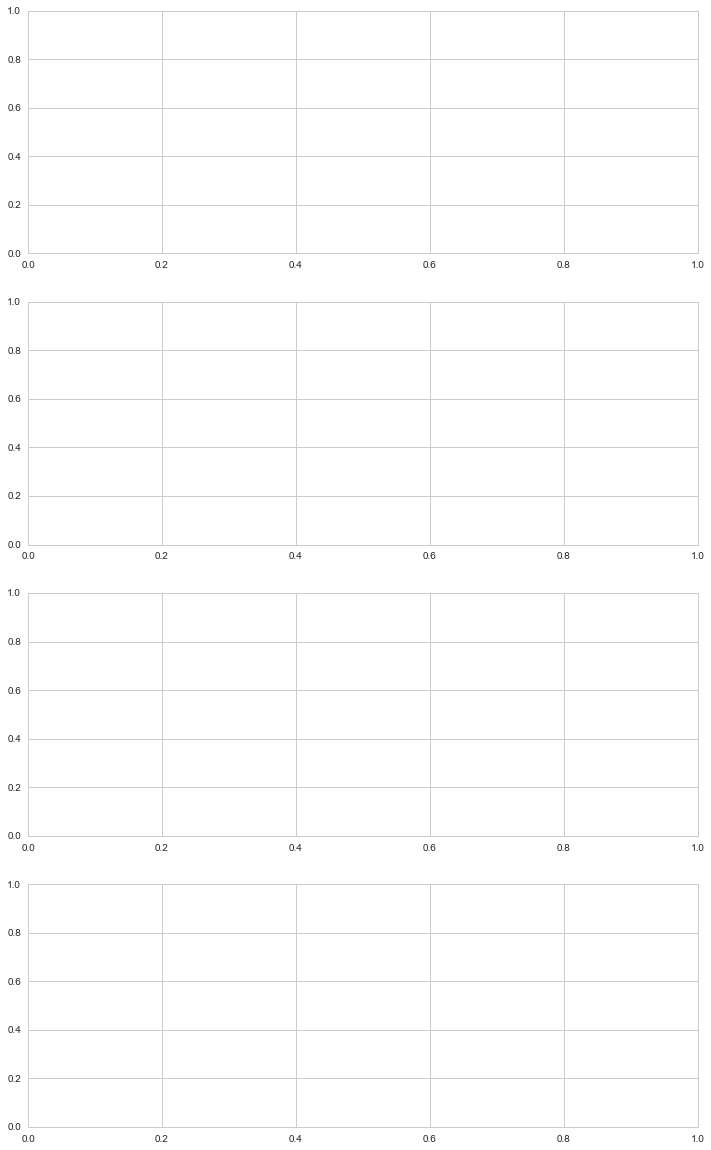

In [43]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(trainData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(trainData=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(trainData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(trainData.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(trainData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')